# Importing Necessary Libraries

In [5]:
# OS and Warning files
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings("ignore")

# Analysis Libraries
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import svm, tree, ensemble, neighbors, linear_model
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualization Library
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

# Import Models

In [9]:
# Loading RL Features Dataset
storm_rl_df = pd.read_csv("../data/storm_rl_norm.csv")
storm_rl_df["cost_category"] = storm_rl_df["cost_category"].astype('category')
storm_rl_df.head()

,storm_names,eff_land_sp,direct,angled,cross,press_mbars,max_sust_winds_kts,storm_surge,storm_tide,moon_phase,low_neap,high_neap,high_ebb,high_tide_line,low_tide_line,norm_cost,cost_category
0,Bob,15.005262,0,1,0,1003,65,0.0,0.0,7,0,1,0,7.5,-0.6,5.963532e+05,moderate
1,Danny,12.080622,1,0,0,987,80,0.0,8.0,27,0,0,0,1.9,-0.4,1.250277e+06,high
2,Elena,19.448238,0,1,0,959,100,10.0,0.0,16,0,1,0,1.4,1.0,3.320953e+07,severe
3,Gloria,31.092933,0,0,0,942,90,0.0,0.0,12,1,0,0,1.3,0.3,0.000000e+00,minimal
4,Gloria,45.238814,0,1,0,961,75,0.0,0.0,12,0,0,0,3.0,0.2,0.000000e+00,minimal


In [14]:
#Loading winds and rain data
winds_rain = pd.read_csv("../data/wind_rain.csv")
winds_rain = winds_rain.drop(columns={"Rain Rate"})
winds_rain.head()

,storm_names,year,month,day,Max Radii,Point Maxima
0,Bob,1985,7,25,NaN,21.50
1,Danny,1985,8,15,NaN,9.80
2,Elena,1985,9,2,NaN,15.67
3,Gloria,1985,9,27,NaN,9.70
4,Gloria,1985,9,27,NaN,9.70


# Import SS Data

In [47]:
# Loading Saffir Simpson Dataset
storm_ss_df = pd.read_csv("../data/storm_ss_norm.csv")
storm_ss_df["cost_category_num"] = storm_ss_df.cost_category.astype('category').cat.codes
storm_ss_df = storm_ss_df.fillna(0)
storm_ss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
storm_names          115 non-null object
SS                   115 non-null int64
norm_cost            115 non-null float64
cost_category        115 non-null object
cost_category_num    115 non-null int8
dtypes: float64(1), int64(1), int8(1), object(2)
memory usage: 3.8+ KB


In [48]:
# X_ss -> features
# y_ss -> labels

X_ss = storm_ss_df.drop(columns={"storm_names","norm_cost","cost_category","cost_category_num"})
y_ss = storm_ss_df.cost_category_num
classes = storm_ss_df.cost_category

## Classifiers

In [49]:
# Dividing X, y into train and test data by 80 events and 35 events 
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_ss, test_size=0.33, random_state = 42) 

In [50]:
ss_acc = []
ss_mse = []

names_ss = []
i = 0

while i <= 30:
    # Dividing X, y into train and test data by 80 events and 35 events 
    X_train, X_test, y_train, y_test = train_test_split(X_ss, y_ss, test_size=0.33, random_state = 42) 

    for name, model in classifiers:
        names.append(name) 

        model.fit(X_train, y_train)
        y_pred= model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        #print("Model:\n%s\n\nAccuracy:\n%s\n"%(name, acc*100))
        ss_acc.append([name, acc])

        mse = mean_squared_error(y_test, y_pred)
        #print("Mean Squared Error:\n%s\n"%(mse))
        ss_mse.append([name, mse])
        
    i = i + 1
print("Done.")

Done.


In [51]:
df_acc_ss = pd.DataFrame(ss_acc, columns = {"names", "acc"})

In [52]:
df_acc_ss.groupby(df_acc_ss.names).describe()

acc                                              \
                    count      mean           std       min       25%   
names                                                                   
Decision Trees       31.0  0.447368  1.692863e-16  0.447368  0.447368   
KNN                  31.0  0.342105  2.257150e-16  0.342105  0.342105   
Logistic Regression  31.0  0.421053  2.821438e-16  0.421053  0.421053   
Random Forest        31.0  0.429542  3.214916e-02  0.368421  0.394737   
SVM                  31.0  0.421053  2.821438e-16  0.421053  0.421053   
XGBoost              31.0  0.447368  1.692863e-16  0.447368  0.447368   

                                                   
                          50%       75%       max  
names                                              
Decision Trees       0.447368  0.447368  0.447368  
KNN                  0.342105  0.342105  0.342105  
Logistic Regression  0.421053  0.421053  0.421053  
Random Forest        0.447368  0.447368  0.500000  
SVM                  0.421053  0.421053  0.421053  
XGBoost              0.447368  0.447368  0.447368

In [53]:
df_mse_ss = pd.DataFrame(ss_mse, columns = {"names", "mse"})

In [54]:
df_mse_ss.groupby(df_mse_ss.names).describe()

mse                                              \
                    count      mean           std       min       25%   
names                                                                   
Decision Trees       31.0  4.605263  1.805720e-15  4.605263  4.605263   
KNN                  31.0  6.684211  1.805720e-15  6.684211  6.684211   
Logistic Regression  31.0  4.394737  1.805720e-15  4.394737  4.394737   
Random Forest        31.0  5.279287  1.062447e+00  3.236842  4.605263   
SVM                  31.0  6.631579  2.708580e-15  6.631579  6.631579   
XGBoost              31.0  4.973684  2.708580e-15  4.973684  4.973684   

                                                   
                          50%       75%       max  
names                                              
Decision Trees       4.605263  4.605263  4.605263  
KNN                  6.684211  6.684211  6.684211  
Logistic Regression  4.394737  4.394737  4.394737  
Random Forest        4.605263  6.289474  7.342105  
SVM                  6.631579  6.631579  6.631579  
XGBoost              4.973684  4.973684  4.973684

# Comparing results

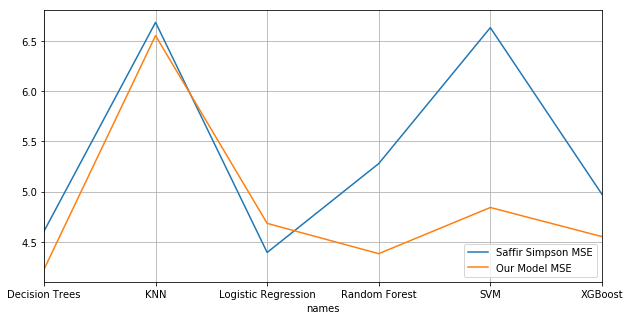

In [55]:
ax = df_mse_ss.groupby(df_mse_ss.names).mean().plot(figsize=(10,5), grid=True)
df_mse.groupby(df_mse.names).mean().plot(figsize=(10,5), grid=True, ax=ax)
ax.legend(['Saffir Simpson MSE', 'Our Model MSE'])

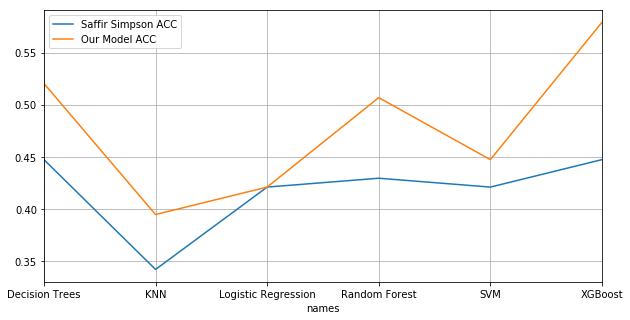

In [56]:
ax = df_acc_ss.groupby(df_acc_ss.names).mean().plot(figsize=(10,5), grid=True)
df_acc.groupby(df_acc.names).mean().plot(figsize=(10,5), grid=True, ax=ax)
ax.legend(['Saffir Simpson ACC', 'Our Model ACC'])